In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
#import seaborn as sns
path_gff_tes = 'data/results/all.noun.no00.gff'
path_gff_genes = 'data/results/Stuberosum_genes_sin_chr0.gff3'
path_genome = 'data/Stuberosum_genome.gff3'
te_classes = ['TRIM', 'LARD','LTR','SINE', 'LINE','TIR','helitron', 'MITE'] #falta mite

In [78]:
df_genome = pd.read_csv(path_genome, sep='\t', header=None)
df_genome.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']

df_tes = pd.read_csv(path_gff_tes, sep='\t', header=None)
df_tes.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']

df_genes = pd.read_csv(path_gff_genes, sep='\t', header=None)
df_genes.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']


In [79]:
df_genes.head(2)

,seqname,source,feature,start,end,score,strand,frame,attribute
0,chr01,phytozomev12,gene,71267700,71269327,.,+,.,ID=PGSC0003DMG400000001.v4.03;Name=PGSC0003DMG...
1,chr01,phytozomev12,gene,71271492,71272645,.,+,.,ID=PGSC0003DMG400000002.v4.03;Name=PGSC0003DMG...


In [80]:
df_genes['gene_id'] = df_genes.attribute.str.split(";").str[0]

In [81]:
df_genes.head(2)

,seqname,source,feature,start,end,score,strand,frame,attribute,gene_id
0,chr01,phytozomev12,gene,71267700,71269327,.,+,.,ID=PGSC0003DMG400000001.v4.03;Name=PGSC0003DMG...,ID=PGSC0003DMG400000001.v4.03
1,chr01,phytozomev12,gene,71271492,71272645,.,+,.,ID=PGSC0003DMG400000002.v4.03;Name=PGSC0003DMG...,ID=PGSC0003DMG400000002.v4.03


In [82]:
df_tes.head(2)

,seqname,source,feature,start,end,score,strand,frame,attribute
0,chr01,ST_annotation,TE,23365,24238,.,+,.,TRIM_id:1163;source_name:RLX_family19_TRIM_ret...
1,chr01,ST_annotation,TE,26437,27916,.,+,.,TRIM_id:5841;source_name:RLX_family32_TRIM_ret...


In [83]:
df_tes['te_id'] = df_tes.attribute.str.split(";").str[0]

In [84]:
df_tes.head(2)

,seqname,source,feature,start,end,score,strand,frame,attribute,te_id
0,chr01,ST_annotation,TE,23365,24238,.,+,.,TRIM_id:1163;source_name:RLX_family19_TRIM_ret...,TRIM_id:1163
1,chr01,ST_annotation,TE,26437,27916,.,+,.,TRIM_id:5841;source_name:RLX_family32_TRIM_ret...,TRIM_id:5841


In [85]:
df_genes['new_start'] = df_genes[['start','end']].min(axis=1)
df_genes['new_send'] = df_genes[['start','end']].max(axis=1)
df_genes['start'] = df_genes['new_start']
df_genes['end'] = df_genes['new_send']
df_genes = df_genes.drop('new_start',axis=1).drop('new_send',axis=1)
df_genes.sort_values(['seqname', 'start'], inplace=True)
print(len(df_genes.index))

37482


In [86]:
#load genome structure
df_genes_genome = {}
for k,chromosome in df_genome.iterrows():
    df_genes_genome[chromosome.seqname] = df_genes[(df_genes.seqname == chromosome.seqname)].reset_index()

In [87]:
#te_classes = ['LARD','SINE']

In [88]:
distances_all = {}
for te_class in te_classes:
    print("class: %s" % (te_class,))
    #calculate distance to closest gene
    df_tes_class = df_tes[df_tes.attribute.str.contains(te_class + "_id")]
    distances_all[te_class] = []
    for k1, te in df_tes_class.iterrows():
        te_id = "%s %s_%s_%s" % (te.te_id, te.seqname, te.start, te.end)
        df_curr = df_genes_genome[te.seqname]
        distances = []
        distance_prev = False
        for k2, gene in df_curr.iterrows():
            gene_id = "%s %s_%s_%s" % (gene.gene_id, gene.seqname, gene.start, gene.end)
            if te.start < gene.start:
                first = te
                second = gene
            else:
                first = gene
                second = te
            distance = max(0, second.start - first.end)
            if distance_prev and distance > distance_prev:
                break
            distances.append((distance,te_id,gene_id))
            distance_prev = distance
        distances_all[te_class].append(min(distances, key=lambda x:x[0]))

class: TRIM
class: LARD
class: LTR
class: SINE
class: LINE
class: TIR
class: helitron
class: MITE


In [89]:
for te_class in te_classes:
    distance = distances_all[te_class]
    with open("data/results/dist_" + te_class + ".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(distance)

In [44]:
import numpy as np
import matplotlib.pyplot as plt

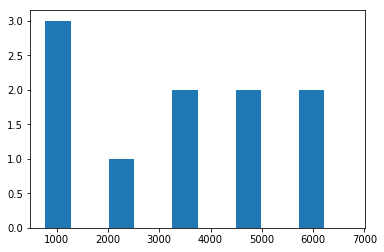

In [45]:
a = np.histogram(distances_all['MITE'])
plt.hist(a, bins='auto')
plt.show()

In [ ]:
distances_kb = {}
distances_all = {}
distances_kb_filtered = {}
for te_class in te_classes:
    #calculate distance to closest gene
    df_tes_class = df_tes[df_tes.attribute.str.contains(te_class + "_id")]
    distances = []
    for k,v in df_tes_class.iterrows():
        midd = (v.start + v.end) / 2
        df_curr = df_genes_genome[v.seqname]
        df_res = df_curr.loc[(df_curr.start - midd).abs().argsort()[:1]]
        if len(df_res.index) > 0:
            closest = (int(df_res.start) + int(df_res.end)) / 2
            distance = abs(midd - closest)
            distances.append(distance)
        else:
            print(v.seqname, midd)
            print(df_res)
            print(df_curr)
            print('error')
    print(te_class, min(distances), max(distances))
    distances_kb[te_class] = []
    for d in distances:
        distances_kb[te_class].append(d/1000)
    #! pip3 install seaborn
    distances_kb_filtered[te_class] = []
    for distance_kb in distances_kb[te_class]:
        if distance_kb <= 500:
            distances_kb_filtered[te_class].append(distance_kb)

In [ ]:
for te_class in te_classes:
    # seaborn histogram
    plt.figure()
 
    sns.distplot(distances_kb_filtered[te_class], hist=True, kde=False, 
                 bins=80, color = 'blue',
                 hist_kws={'edgecolor':'black'},rug=False)
    # Add labels
    plt.title(te_class + ' distance to closest gene in the genome')
    plt.xlabel('Distance to closest gene (kb)')
    plt.ylabel('Number of ' + te_class)
    plt.savefig('data/results/plots/histogram' + te_class + '.png', dpi=800,bbox_inches='tight')

